In [1]:
import numpy as np
import sunode
import sympy as sym
import matplotlib.pyplot as plt

import sunode.symode.paramset
import sunode.symode.problem
import sunode.wrappers.as_theano

import theano
import theano.tensor as tt

### Define ode using sympy

In [2]:
def make_ode():
    # Define parameters of the ode.
    # Parameters marked with `False` are assumed to be fixed.
    paramset = sunode.symode.paramset.ParamSet(
        [
            ('a', True),
            ('b', True),
            ('c', True),
            ('d', False),
            ('e', False),
            ('f', [
                ('g', False, (3,))
            ])
        ],
        {
            'a': 0.1,
            'b': 0.22,
            'c': 0.11,
            'd': 0.1,
            'e': 0.5,
            'f': {
                'g': np.ones(3)
            }
        }
    )

    # Declare state variables
    states = {
        'x': (),
        'y': (),
    }
    
    # Define the right hand side of the ode
    def rhs_sympy(t, y, params):
        return {
            'x': y.y,
            'y': params.b,
        }

    return sunode.symode.problem.SympyOde(paramset, states, rhs_sympy)

In [3]:
ode = make_ode()

tvals = np.linspace(0, 10, 20)
y0 = np.ones(ode.n_states)

### Solve without gradients

50.3 µs ± 447 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


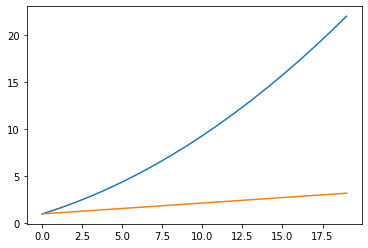

In [4]:
solver = sunode.solver.Solver(ode)
out = solver.make_output_buffers(tvals)
solver.solve(0, tvals, y0, out)
%timeit solver.solve(0, tvals, y0, out)
plt.plot(out);

### Solve with sensitivities

In [5]:
sens0 = np.zeros((ode.n_params, ode.n_states))

151 µs ± 2.81 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


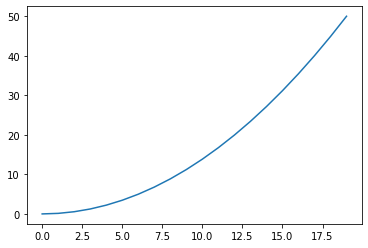

In [6]:
solver = sunode.solver.Solver(ode, compute_sens=True, sens_mode='simultaneous')
out, sens_out = solver.make_output_buffers(tvals)
%timeit solver.solve(0, tvals, y0, out, sens0=sens0, sens_out=sens_out)
plt.plot(sens_out[:, 1, 0]);

### Solve with adjoint

In [7]:
solver = sunode.solver.AdjointSolver(ode)
out, grad_out, lamda_out = solver.make_output_buffers(tvals)

grads = np.ones(out.shape)
grads[:, 0] = 0

In [8]:
%%timeit
solver.solve_forward(0, tvals, y0, out)
solver.solve_backward(tvals[-1], 0, tvals, grads, grad_out, lamda_out)

410 µs ± 27 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
solver.as_xarray(tvals, out)

<xarray.Dataset>
Dimensions:         (parameters_f_g: 3, time: 20)
Coordinates:
  * time            (time) float64 0.0 0.5263 1.053 1.579 ... 8.947 9.474 10.0
  * parameters_f_g  (parameters_f_g) float64 1.0 1.0 1.0
Data variables:
    solution_x      (time) float64 1.0 1.557 2.175 2.853 ... 18.75 20.35 22.0
    solution_y      (time) float64 1.0 1.116 1.232 1.347 ... 2.968 3.084 3.2
    parameters_a    float64 0.1
    parameters_b    float64 0.22
    parameters_c    float64 0.11
    parameters_d    float64 0.1
    parameters_e    float64 0.5

### Integrate into theano and check gradients

In [10]:
tvals = np.arange(1, 10)

In [11]:
params = tt.dvector('params')
y0 = tt.dvector('y0')
solve_ode = sunode.wrappers.as_theano.SolveODEAdjoint(solver, 0, tvals)
solution = solve_ode(y0, params)

loss = (solution ** 2).sum()
grad_p, grad_y0 = tt.grad(loss, [params, y0])
func = theano.function([y0, params], [loss, grad_p, grad_y0])

# Explicit solution
loss = ((
    ((0.5 * tvals ** 2 * params[1] + tvals * y0[1]) + y0[0]) ** 2
    + (tvals * params[1] + y0[1]) ** 2
)).sum()
grad_p, grad_y0 = tt.grad(loss, [params, y0])

func2 = theano.function([y0, params], [loss, grad_p, grad_y0])

In [12]:
p = np.random.randn(3)
y0 = np.random.randn(2)
func(y0, p)

[array(2799.56607648),
 array([   0.        , 6787.19817836,    0.        ]),
 array([ 241.49532577, 1759.40589498])]

In [13]:
func2(y0, p)

[array(2799.56607648),
 array([   0.        , 6787.19817831,    0.        ]),
 array([ 241.49532577, 1759.40589498])]

In [14]:
eps = 1e-8
h = np.zeros_like(y0)
h[0] += eps
a = func(y0, p)
b = func(y0 + h, p)

In [15]:
print((b[0] - a[0]) / h)
print(a[2])

[241.4951723         inf]
[ 241.49532577 1759.40589498]


In [16]:
eps = 1e-8
h = np.zeros_like(p)
h[1] += eps
a = func(y0, p)
b = func(y0, p + h)

In [17]:
print((b[0] - a[0]) / h)
print(a[1])

[          inf 6787.19829921           inf]
[   0.         6787.19817836    0.        ]


### Use in pymc3

In [18]:
import pymc3 as pm

with pm.Model() as model:
    params = pm.Normal('params', sd=10, shape=ode.n_params)
    y0 = pm.Normal('y0', shape=ode.n_states)
    
    solve_ode = sunode.wrappers.as_theano.SolveODEAdjoint(solver, 0, tvals)
    mu = solve_ode(y0, params)
    error = 0.8 * np.random.randn(len(tvals))
    pm.Normal('y', mu=mu[:, 0], sd=0.8, observed=tvals ** 2 + tvals + 5 + error)
    
    trace = pm.sample(chains=2, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y0, params]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:33<00:00, 59.19draws/s] 


In [19]:
with model:
    tr = pm.sample_posterior_predictive(trace)

100%|██████████| 1000/1000 [00:00<00:00, 1691.56it/s]


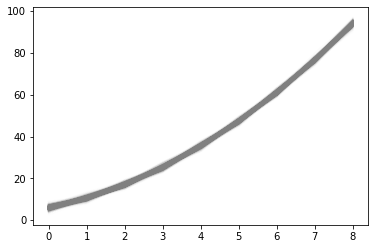

In [20]:
plt.plot(tr['y'].T, color='grey', alpha=0.01);

In [21]:
import seaborn as sns

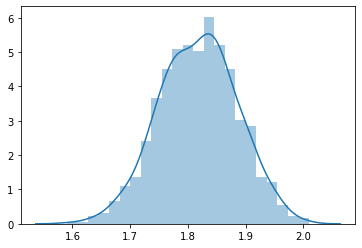

In [22]:
sns.distplot(trace['params'][:, 1])

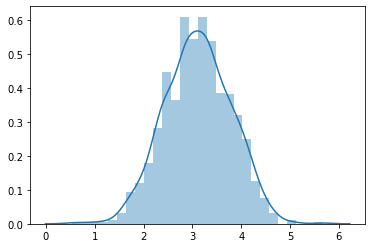

In [23]:
sns.distplot(trace['y0'][:, 0])